In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

## Read Dataset

In [2]:
#df = pd.read_csv('../data/movielens-dataset/ratings.dat')
#df = pd.read_csv('../data/movielens100k/ratings.csv', sep="::", names=['userId', 'movieId', 'rating', 'timestamp'])
df = pd.read_csv('../data/movielens100k/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


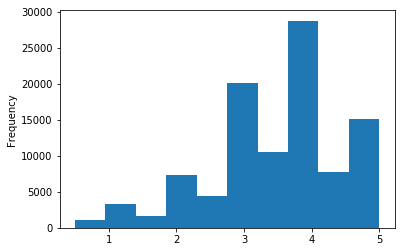

In [3]:
df.rating.plot(kind='hist')

In [4]:
df_user_idx = df[['userId']].drop_duplicates().reset_index(drop=True)\
                .reset_index().rename(columns={'index': 'userId_idx'})
df_user_idx.shape

(671, 2)

In [5]:
df_user_idx.head()

,userId_idx,userId
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [6]:
df_movie_idx = df[['movieId']].drop_duplicates().reset_index(drop=True)\
                    .reset_index().rename(columns={'index': 'movieId_idx'})
df_movie_idx.shape

(9066, 2)

In [7]:
df_movie_idx.head()

,movieId_idx,movieId
0,0,31
1,1,1029
2,2,1061
3,3,1129
4,4,1172


### Preparate Train Dataset

In [8]:
from scipy.sparse.csr import csr_matrix
from scipy.sparse import save_npz, load_npz


In [9]:
df_train = df#.groupby('userId').agg({'movieId': lambda x: list(x), 'rating': lambda x: list(x)})

# Merge Dataset
df_train = df_train.merge(
                df_user_idx, on='userId', how='inner')\
            .merge(
                df_movie_idx, on='movieId', how='inner')


df_train.head()

,userId,movieId,rating,timestamp,userId_idx,movieId_idx
0,1,31,2.5,1260759144,0,0
1,7,31,3.0,851868750,6,0
2,31,31,4.0,1273541953,30,0
3,32,31,4.0,834828440,31,0
4,36,31,3.0,847057202,35,0


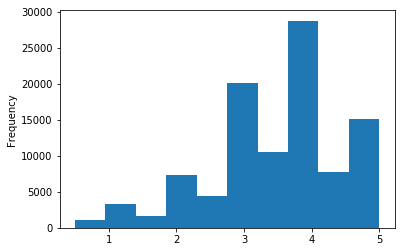

In [10]:
df_train.rating.plot(kind='hist')

In [11]:
#df.groupby('userId').agg({'movieId': lambda x: list(x), 'rating': lambda x: list(x)})

In [12]:
#df_train['rating'] = (df_train['rating'] > 0).astype(float)
spc_data = csr_matrix((df_train['rating'].values, (df_train.userId_idx.values, df_train.movieId_idx.values)), 
                shape=(len(df_user_idx), len(df_movie_idx)))

spc_data.toarray()

array([[2.5, 3. , 3. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [13]:
import gc
gc.collect()
del df

## Model

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout

In [15]:
class AutoEncRec(Model):
    '''Vanilla Autoencer'''
    
    def __init__(self, input_size, n_dims = [64, 32, 64], dropout_rate = 0.2):
        super(AutoEncRec,self).__init__()
        self.input_size = input_size

        self.enc_1 = Dense(n_dims[0], input_shape = (input_size, ), activation='selu')
        self.enc_2 = Dense(n_dims[1], activation='selu')
        self.dec_1 = Dense(n_dims[2], activation='selu')
        self.dec_2 = Dense(input_size, activation='linear')     
        self.dropout = Dropout(dropout_rate)

    def encoder(self, x):
        net = self.enc_1(x)
        net = self.enc_2(net)
        return net
    
    def decoder(self, x):
        net = self.dec_1(x)
        net = self.dec_2(net)
        return net

    def call(self, inputs):
        net = self.decoder(self.dropout(self.encoder(inputs)))
        return net

def masked_mse(mask_value):
    def f(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        # in case mask_true is 0 everywhere, the error would be nan, therefore divide by at least 1
        # this doesn't change anything as where sum(mask_true)==0, sum(masked_squared_error)==0 as well
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
    f.__name__ = str('Masked MSE (mask_value={})'.format(mask_value))
    return f

In [31]:
input_size = len(df_movie_idx)

model = AutoEncRec(input_size = input_size, n_dims = [128, 64, 128])
model.compile(optimizer='adam', loss='mse')

In [32]:
X_train    = spc_data.toarray()

#train_data = tf.data.Dataset.from_tensor_slices(X_train).batch(128).shuffle(buffer_size = 1024) 

In [33]:
hist = model.fit(X_train, X_train, 
                validation_split=0.2, 
                batch_size = 10, 
                epochs = 20)

Train on 536 samples, validate on 135 samples
Epoch 1/20
536/536 [==============================] - 1s 2ms/sample - loss: 0.1963 - val_loss: 0.2031
Epoch 2/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1765 - val_loss: 0.1961
Epoch 3/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1668 - val_loss: 0.1924
Epoch 4/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1630 - val_loss: 0.1905
Epoch 5/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1581 - val_loss: 0.1905
Epoch 6/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1554 - val_loss: 0.1895
Epoch 7/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1484 - val_loss: 0.1876
Epoch 8/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1457 - val_loss: 0.1872
Epoch 9/20
536/536 [==============================] - 1s 1ms/sample - loss: 0.1426 - val_loss: 0.1877
Epoch 10/20
536/536 [===============

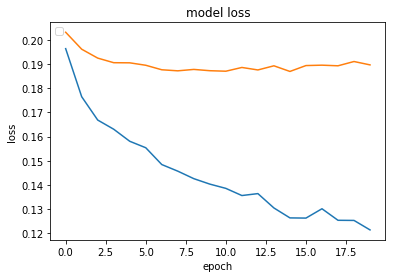

In [34]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [35]:
#df_movie = pd.read_csv('../data/ml-latest-small/movies.csv')
df_movie = pd.read_csv('../data/movielens100k/movies.csv')
df_movie = df_movie.merge(df_movie_idx).set_index('movieId_idx')
df_movie.head()

,movieId,title,genres
movieId_idx,,,
417,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
650,2,Jumanji (1995),Adventure|Children|Fantasy
319,3,Grumpier Old Men (1995),Comedy|Romance
2084,4,Waiting to Exhale (1995),Comedy|Drama|Romance
651,5,Father of the Bride Part II (1995),Comedy


In [36]:
id_view    = [1, 3114, 87222, 84944, 260, 1196, 1210, 2628, 79006, 2116, 7153, 5952]
idx_view   = df_movie_idx.set_index("movieId").loc[id_view].values.reshape(-1)

In [38]:
df_movie[df_movie.movieId.isin(id_view)]

,movieId,title,genres
movieId_idx,,,
417,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
143,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
179,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
106,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2588,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
278,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
344,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
412,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
129,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [39]:
data = np.ones(len(idx_view))
row  = np.zeros(len(idx_view))
col  = idx_view

data_input = csr_matrix((data, (row, col)), shape=(1, input_size)).toarray()

In [40]:
data_pred  = model.predict(data_input)[0]

In [41]:
idx_pred  = list(set(list(range(len(df_movie)))) - set(idx_view))

data_pred = model.predict(data_input)[0]
data_pred = dict(
                sorted(
                    zip(
                        list(idx_pred), 
                        list(data_pred[idx_pred].astype(float))
                    ), 
                key=lambda x: x[1],
            reverse=True))
data_pred            

0.11847579479217529,
 832: 0.11832930147647858,
 628: 0.11826549470424652,
 183: 0.11796973645687103,
 725: 0.11790475994348526,
 182: 0.11747411638498306,
 1019: 0.11745907366275787,
 1690: 0.1172424703836441,
 368: 0.1170358657836914,
 1537: 0.11700350791215897,
 1807: 0.11696381121873856,
 541: 0.11669538170099258,
 1218: 0.11661325395107269,
 840: 0.11596618592739105,
 141: 0.11595574766397476,
 507: 0.11563268303871155,
 517: 0.11559305340051651,
 774: 0.11551587283611298,
 1261: 0.11512060463428497,
 319: 0.11483289301395416,
 120: 0.11481495946645737,
 396: 0.11476682871580124,
 3327: 0.11444074660539627,
 2465: 0.114391028881073,
 458: 0.11428582668304443,
 688: 0.11423052102327347,
 0: 0.11381220072507858,
 811: 0.11351388692855835,
 25: 0.11315138638019562,
 19: 0.11295231431722641,
 1625: 0.11278325319290161,
 265: 0.11277732998132706,
 3105: 0.11248508095741272,
 184: 0.11199792474508286,
 1419: 0.11190980672836304,
 1654: 0.11165784299373627,
 869: 0.11122594028711319,
 18

In [42]:
df_movie.loc[list(data_pred.keys())][:10]

,movieId,title,genres
movieId_idx,,,
480,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
402,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
137,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
180,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
72,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
88,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
564,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
477,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
105,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance


In [44]:
df_movie.loc[idx_view]#[:10]

,movieId,title,genres
movieId_idx,,,
417,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
344,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
1678,87222,Kung Fu Panda 2 (2011),Action|Adventure|Animation|Children|Comedy|IMAX
3281,84944,Rango (2011),Action|Adventure|Animation|Children|Comedy|Wes...
143,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
179,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
106,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
278,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
5176,79006,Empire of Dreams: The Story of the 'Star Wars'...,Documentary
